# SMS Spam Classifier - This notebook demonstrates how to build a robust machine learning model to classify SMS as Spam or Not Spam using natural language processing (NLP) techniques.

In [ ]:
# import all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import re
import spacy
from sklearn.model_selection import train_test_split, cross_val_score
from collections import Counter
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import FunctionTransformer
import optuna

In [ ]:
# import dataset
df = pd.read_csv("spam.csv", encoding='latin-1')

# Data Understanding

In [ ]:
# check top 5 rows of dataset
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# check shape of dataset
df.shape

(5572, 5)

In [ ]:
# some information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
# remove some columns because they have few not null values
df = df[["v1", "v2"]]

In [ ]:
# remame columns
df = df.rename(columns={"v1" : "is_spam", "v2" : "text"})

In [ ]:
# check dataset have duplicate rows or not
df.duplicated().sum()

np.int64(403)

In [ ]:
# drop duplicate rows
df.drop_duplicates(inplace=True)

# Feature Engineering

In [ ]:
# label encoding of target variable
df["is_spam"] = df["is_spam"].map({"spam" : 1, "ham" : 0})

In [ ]:
# calculate length of each text
def len_calculator(text):
    text = re.sub(r"[^\w\s]",'', text)
    text = re.sub(r"_", " ", text)
    return len(text.split(" "))

df["sent_len(in words)"] = df["text"].apply(len_calculator)

In [ ]:
# extract top n words from ham dataset
text = " ".join(df[df["is_spam"]==0]["text"]).lower()
text = re.sub(r"[^\w\s]",'', text)

doc = nlp(text)
without_stopwords = [word.text for word in doc if not word.is_stop and word.text.strip() != ""]

word_counts = Counter(without_stopwords)
top_n_ham_words = pd.DataFrame(word_counts.most_common(20), columns=["Word", "Counts"])

In [ ]:
# extract top n words from spam dataset
text = " ".join(df[df["is_spam"]==1]["text"]).lower()
text = re.sub(r"[^\w\s]",'', text)

doc = nlp(text)
without_stopwords = [word.text for word in doc if not word.is_stop and word.text.strip() != ""]

word_counts = Counter(without_stopwords)
top_n_spam_words = pd.DataFrame(word_counts.most_common(20), columns=["Word", "Counts"])

# Data Visualization And  Calculations

In [ ]:
# some mathmatical calculation on ham dataset
df[df["is_spam"] == 0][["sent_len(in words)"]].describe()

,sent_len(in words)
count,4516.000000
mean,14.291851
std,11.238828
min,1.000000
25%,7.000000
50%,11.000000
75%,19.000000
max,171.000000


In [ ]:
# some mathmatical calculation on spam dataset
df[df["is_spam"] == 1][["sent_len(in words)"]].describe()

,sent_len(in words)
count,653.000000
mean,23.733538
std,5.984084
min,2.000000
25%,22.000000
50%,25.000000
75%,28.000000
max,35.000000


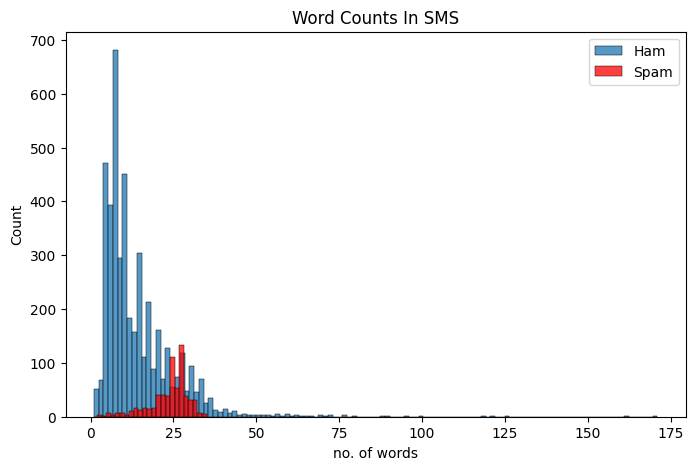

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df[df["is_spam"]==0]["sent_len(in words)"], label="Ham")
sns.histplot(df[df["is_spam"]==1]["sent_len(in words)"], label="Spam", color="red")
plt.title("Word Counts In SMS")
plt.xlabel("no. of words")
plt.legend()
plt.show()

Spam messages are larger in words comapred to ham messages.

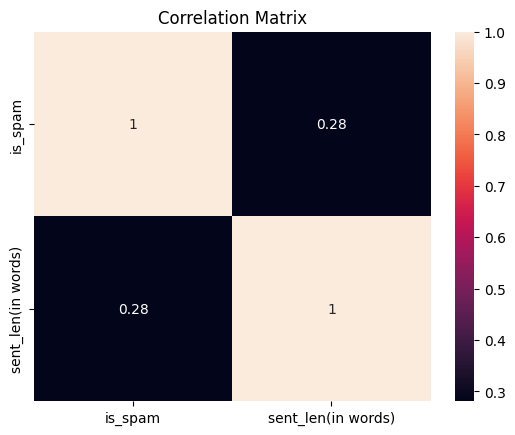

In [ ]:
sns.heatmap(df.drop("text", axis=1).corr(), annot=True)
plt.title("Correlation Matrix")
plt.show()

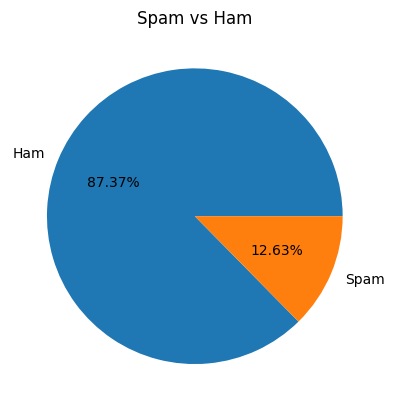

In [ ]:
plt.pie(df["is_spam"].value_counts(), labels=["Ham", "Spam"], autopct="%0.2f%%")
plt.title("Spam vs Ham")
plt.show()

Data is imbalanced.

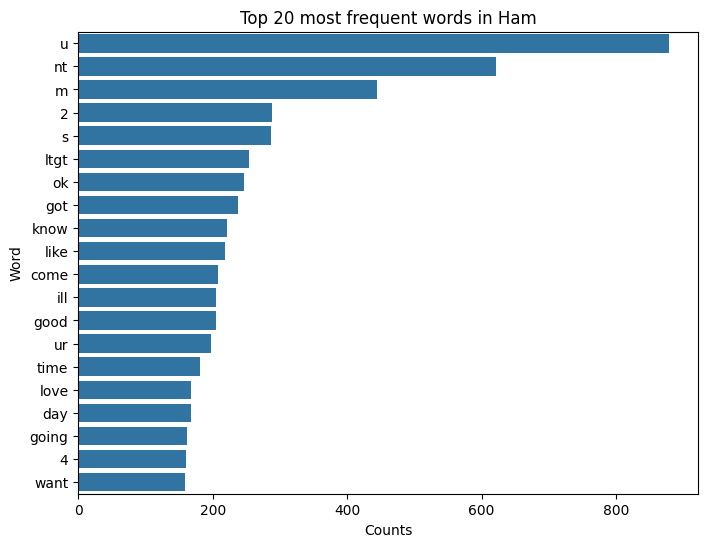

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(y=top_n_ham_words["Word"], x=top_n_ham_words["Counts"])
plt.title("Top 20 most frequent words in Ham")
plt.show()

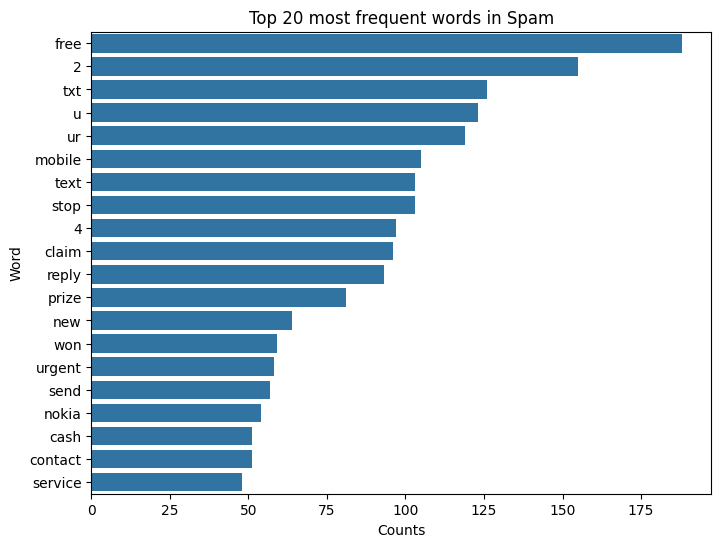

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(y=top_n_spam_words["Word"], x=top_n_spam_words["Counts"])
plt.title("Top 20 most frequent words in Spam")
plt.show()

Corpus also have some slang words and contractions.

# Preparing Data For Training And Testing

In [ ]:
# separating dependent and independent variable
x = df["text"]
y = df["is_spam"]

In [ ]:
# splitting data for training and testing
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

# Making NLP Pipeline

In [ ]:
# import slang words csv file and convert it into dictonary
slang_words_df = pd.read_csv("slang_words.csv")
slang_words_dic = dict(zip(slang_words_df["slang"], slang_words_df["full"]))

In [ ]:
class TextPreprocessing(BaseEstimator, TransformerMixin):
    def __init__(self, slang_words_dic):
        self.slang_words_dic= slang_words_dic

    def fit(self, x, y = None):
        return self

    def transform(self, x):
        new_x = [self._text_cleaner(text) for text in x]
        return new_x

    def _text_cleaner(self, text):
        # 1. lowercase
        text = text.lower()
        # 2. expand contractions
        text = contractions.fix(text)
        # 3. remove punctuation
        text = re.sub(r"[^\w\s]", " ", text)
        # 4. remove underscores
        text = text.replace("_", " ")
        # 5. replace slang words
        without_slang_words = [self.slang_words_dic.get(word, word) for word in text.split()]
        text = " ".join(without_slang_words)
        # 6. remove extra space
        text = re.sub(r"\s+", " ", text).strip()
        # 7. remove stopwords and apply lemmatization
        doc = nlp(text)
        cleaned_text = [token.lemma_ for token in doc if not token.is_stop and token.text.strip() != ""]
        # 8. return cleaned text
        return " ".join(cleaned_text)

# Model Selection Using Cross Validation Score

In [ ]:
# making dictionary of models to check cross validation score
models = {
    "BernoulliNB" : BernoulliNB(),
    "LogisticRegression" : LogisticRegression(),
    "DecisionTree" : DecisionTreeClassifier(random_state=42),
    "RandomForest" : RandomForestClassifier(random_state=42),
    "MultinomialNB" : MultinomialNB(),
    "GaussianNB" : GaussianNB(),
    "KNN" : KNeighborsClassifier(),
    "SVM" : SVC()
}

In [ ]:
# evaluate multiple algorithms using cross validation score
for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", TextPreprocessing(slang_words_dic = slang_words_dic)),
        ("vectorizer", TfidfVectorizer(max_features=3000)),
        ("to_dense", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
        ("model", model)
    ])

    scores = cross_val_score(pipe, x, y, cv=5, scoring="f1_macro")
    print(f'{name}: {scores.mean()}')

BernoulliNB: 0.9507495721498531
LogisticRegression: 0.913537746861578
DecisionTree: 0.9160650376933945
RandomForest: 0.9443740216513852
MultinomialNB: 0.9345268850100883
GaussianNB: 0.718309931612725
KNN: 0.6999865992036475
SVM: 0.9438936709062034


BernoulliNB, RandomForest and SVM gives good results.

# Hyperparameter Tuning Of RandomForest

In [ ]:
# create objective function to find best parameter of random forest
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestClassifier(
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        max_features = max_features,
        random_state = 42,
        n_jobs = -1
    )

    pipe = Pipeline([
        ("preprocessor", TextPreprocessing(slang_words_dic = slang_words_dic)),
        ("vectorizer", TfidfVectorizer(max_features=3000)),
        ("to_dense", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
        ("model", model)
    ])

    pipe.fit(xtrain, ytrain)
    ypre = pipe.predict(xtest)
    return f1_score(ytest, ypre, average="macro")

In [52]:
# finding best hyperparameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2025-08-02 16:27:35,359] A new study created in memory with name: no-name-fcaa82ca-8b55-49e6-9b3d-6d0142a53a78
[I 2025-08-02 16:28:32,205] Trial 0 finished with value: 0.9485572139303482 and parameters: {'n_estimators': 295, 'max_depth': 31, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9485572139303482.
[I 2025-08-02 16:29:34,122] Trial 1 finished with value: 0.8592047930283224 and parameters: {'n_estimators': 225, 'max_depth': 44, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.9485572139303482.
[I 2025-08-02 16:30:24,685] Trial 2 finished with value: 0.8347826929036257 and parameters: {'n_estimators': 68, 'max_depth': 46, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9485572139303482.
[I 2025-08-02 16:31:13,468] Trial 3 finished with value: 0.5827654232424677 and parameters: {'n_estimators': 128, 'max_depth': 41, 'mi

In [53]:
print(f'best value: {study.best_value}')
print(f'best hyperparameters: {study.best_params}')

best value: 0.9531413504717176
best hyperparameters: {'n_estimators': 250, 'max_depth': 34, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}


# Creating ML Pipeline With RandomForestClassifier Model

In [ ]:
# training random forest with their best hyperparameters
rf_model = RandomForestClassifier(
        n_estimators = 250,
        max_depth = 34,
        min_samples_split = 8,
        min_samples_leaf = 3,
        max_features = "sqrt",
        random_state = 42,
        n_jobs = -1
)

rf_model_pipe = Pipeline([
    ("preprocessor", TextPreprocessing(slang_words_dic = slang_words_dic)),
    ("vectorizer", TfidfVectorizer(max_features=3000)),
    ("to_dense", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ("model", rf_model)
])

rf_model_pipe.fit(xtrain, ytrain)

Pipeline(steps=[('preprocessor',
                 TextPreprocessing(slang_words_dic={'afaik': 'as far as i know',
                                                    'afk': 'away from keyboard',
                                                    "ain't": 'is not',
                                                    'asap': 'as soon as '
                                                            'possible',
                                                    'ate': 'did really well',
                                                    'atm': 'at the moment',
                                                    'b4': 'before',
                                                    'b4n': 'bye for now',
                                                    'bae': 'before anyone else',
                                                    'basic': 'mainstream',
                                                    'bc': 'because',
                                                    'bcoz': 'because',
                                                    'bday': 'birthday',
                                                    'bf': 'boyfriend',
                                                    'bff...
                                                    'bruh': 'bro',
                                                    'btw': 'by the way',
                                                    'bussin': 'delicious',
                                                    'cap': 'lie',
                                                    'clapback': 'witty '
                                                                'response',
                                                    'congrats': 'congratulations',
                                                    'cos': 'because',
                                                    'coz': 'because',
                                                    'cuz': 'because', ...})),
                ('vectorizer', TfidfVectorizer(max_features=3000)),
                ('model',
                 RandomForestClassifier(max_depth=34, min_samples_leaf=3,
                                        min_samples_split=8, n_estimators=250,
                                        n_jobs=-1, random_state=42))])

# Hyperparameter Tuning Of SVM

In [59]:
# create objective function to find best parameter of svm
def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])

    # kernel specific sample space
    if kernel in ['rbf', 'poly', 'sigmoid']:
        gamma = trial.suggest_loguniform('gamma', 1e-4, 1e0)
    else:
        gamma = 'auto'

    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5)
    else:
        degree = 3

    model = SVC(
        C = C,
        kernel = kernel,
        gamma = gamma,
        degree = degree,
        random_state = 42,
        verbose=False
    )

    pipe = Pipeline([
        ("preprocessor", TextPreprocessing(slang_words_dic = slang_words_dic)),
        ("vectorizer", TfidfVectorizer(max_features=3000)),
        ("to_dense", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
        ("model", model)
    ])

    pipe.fit(xtrain, ytrain)
    ypre = pipe.predict(xtest)
    return f1_score(ytest, ypre, average="macro")

In [61]:
# finding best hyperparameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2025-08-02 17:11:49,820] A new study created in memory with name: no-name-4c807e2c-cf5f-4ee3-a29a-3a51c4be80ec
[I 2025-08-02 17:12:47,281] Trial 0 finished with value: 0.9652027595490493 and parameters: {'C': 4.973325437137595, 'kernel': 'linear'}. Best is trial 0 with value: 0.9652027595490493.
/tmp/ipython-input-2777894052.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e0)
[I 2025-08-02 17:13:48,061] Trial 1 finished with value: 0.4622984919396776 and parameters: {'C': 0.12820460150924695, 'kernel': 'sigmoid', 'gamma': 0.0028546990842183975}. Best is trial 0 with value: 0.9652027595490493.
/tmp/ipython-input-2777894052.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/relea

In [66]:
print(f'best value: {study.best_value}')
print(f'best hyperparameters: {study.best_params}')

best value: 0.9691126303652118
best hyperparameters: {'C': 1.0244511508114933, 'kernel': 'linear'}


# Creating ML Pipeline with SVC Model

In [ ]:
# training svc model with their best hyperparameters
svc_model = SVC(
        C = 1.0244511508114933,
        kernel = 'linear',
        random_state = 42
)

svc_model_pipe = Pipeline([
    ("preprocessor", TextPreprocessing(slang_words_dic = slang_words_dic)),
    ("vectorizer", TfidfVectorizer(max_features=3000)),
    ("to_dense", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ("model", svc_model)
])

svc_model_pipe.fit(xtrain, ytrain)

Pipeline(steps=[('preprocessor',
                 TextPreprocessing(slang_words_dic={'afaik': 'as far as i know',
                                                    'afk': 'away from keyboard',
                                                    "ain't": 'is not',
                                                    'asap': 'as soon as '
                                                            'possible',
                                                    'ate': 'did really well',
                                                    'atm': 'at the moment',
                                                    'b4': 'before',
                                                    'b4n': 'bye for now',
                                                    'bae': 'before anyone else',
                                                    'basic': 'mainstream',
                                                    'bc': 'because',
                                                    'bcoz': 'because',
                                                    'bday': 'birthday',
                                                    'bf': 'boyfriend',
                                                    'bff...
                                                    'boo': 'significant other',
                                                    'brb': 'be right back',
                                                    'bro': 'brother',
                                                    'broz': 'brothers',
                                                    'bruh': 'bro',
                                                    'btw': 'by the way',
                                                    'bussin': 'delicious',
                                                    'cap': 'lie',
                                                    'clapback': 'witty '
                                                                'response',
                                                    'congrats': 'congratulations',
                                                    'cos': 'because',
                                                    'coz': 'because',
                                                    'cuz': 'because', ...})),
                ('vectorizer', TfidfVectorizer(max_features=3000)),
                ('model',
                 SVC(C=1.0244511508114933, kernel='linear', random_state=42))])

# Creating ML Pipeline with BernoulliNB

In [ ]:
bnb_model_pipe =Pipeline([
    ("preprocessor", TextPreprocessing(slang_words_dic = slang_words_dic)),
    ("vectorizer", TfidfVectorizer(max_features=3000)),
    ("to_dense", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ("model", BernoulliNB())
])

bnb_model_pipe.fit(xtrain, ytrain)

Pipeline(steps=[('preprocessor',
                 TextPreprocessing(slang_words_dic={'afaik': 'as far as i know',
                                                    'afk': 'away from keyboard',
                                                    "ain't": 'is not',
                                                    'asap': 'as soon as '
                                                            'possible',
                                                    'ate': 'did really well',
                                                    'atm': 'at the moment',
                                                    'b4': 'before',
                                                    'b4n': 'bye for now',
                                                    'bae': 'before anyone else',
                                                    'basic': 'mainstream',
                                                    'bc': 'because',
                                                    'bcoz': 'because',
                                                    'bday': 'birthday',
                                                    'bf': 'boyfriend',
                                                    'bff...
                                                    'biggie': 'big',
                                                    'bih': 'bitch',
                                                    'boo': 'significant other',
                                                    'brb': 'be right back',
                                                    'bro': 'brother',
                                                    'broz': 'brothers',
                                                    'bruh': 'bro',
                                                    'btw': 'by the way',
                                                    'bussin': 'delicious',
                                                    'cap': 'lie',
                                                    'clapback': 'witty '
                                                                'response',
                                                    'congrats': 'congratulations',
                                                    'cos': 'because',
                                                    'coz': 'because',
                                                    'cuz': 'because', ...})),
                ('vectorizer', TfidfVectorizer(max_features=3000)),
                ('model', BernoulliNB())])

# Evaluation

In [87]:
# create dictionary of all 3 final pipelines
pipelines = {
    "Random Forest" : rf_model_pipe,
    "SVC" : svc_model_pipe,
    "BernoulliNB" : bnb_model_pipe
}

In [88]:
# check classification report of each pipeline
for name, each_pipeline in pipelines.items():
    ypre = each_pipeline.predict(xtest)
    print(name)
    print(classification_report(ytest, ypre))
    print("\n")

Random Forest
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       889
           1       0.99      0.86      0.92       145

    accuracy                           0.98      1034
   macro avg       0.98      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034



SVC
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       889
           1       0.98      0.92      0.95       145

    accuracy                           0.99      1034
   macro avg       0.98      0.96      0.97      1034
weighted avg       0.99      0.99      0.99      1034



BernoulliNB
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       889
           1       0.98      0.86      0.92       145

    accuracy                           0.98      1034
   macro avg       0.98      0.93      0.95      1034
weighted avg       0.98      0.98      0

# Result - After overall process, all 3 models gives good results. And in those 3 models, SVM performed very well to classify SMS.